In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

In [14]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [15]:
class Network(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 250)
        self.fc3 = nn.Linear(250, 75)
        self.fc4 = nn.Linear(75, 10)
        
    def forward(self, x):

        x = x.view(x.shape[0], 28*28)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.log_softmax(x)
        return x


In [16]:
model = Network()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 3

In [17]:
def train(trainloader, model, criterion, optimizer):
    size = len(trainloader.dataset)

    model.train()
    for i, (images, labels) in enumerate(iter(trainloader)):
        
        output = model(images)
        output = torch.exp(output)
        loss = criterion(output, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            loss, current = loss.item(), i * len(images)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
def test(testloader, model, criterion):
    num_batches = len(testloader)
    size = len(testloader.dataset)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):
            output = model(images)
            output = torch.exp(output)

            test_loss += criterion(output, labels).item()
            correct += (output.argmax(1) == labels).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [19]:
for t in range(epochs):
    print(f'Epoch {t+1}')
    train(trainloader, model, criterion, optimizer)
    test(testloader, model, criterion)

Epoch 1


C:\Users\Igor\AppData\Local\Temp/ipykernel_9936/184824563.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


loss: 2.305217  [    0/60000]
loss: 0.533837  [10000/60000]
loss: 0.510302  [20000/60000]
loss: 0.542208  [30000/60000]
loss: 0.521251  [40000/60000]
loss: 0.530187  [50000/60000]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.529120 

Epoch 2
loss: 0.512957  [    0/60000]
loss: 0.428644  [10000/60000]
loss: 0.636452  [20000/60000]
loss: 0.527091  [30000/60000]
loss: 0.513864  [40000/60000]
loss: 0.534514  [50000/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.440399 

Epoch 3
loss: 0.547144  [    0/60000]
loss: 0.334403  [10000/60000]
loss: 0.624789  [20000/60000]
loss: 0.380887  [30000/60000]
loss: 0.475992  [40000/60000]
loss: 0.304679  [50000/60000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.444154 



C:\Users\Igor\AppData\Local\Temp/ipykernel_9936/184824563.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


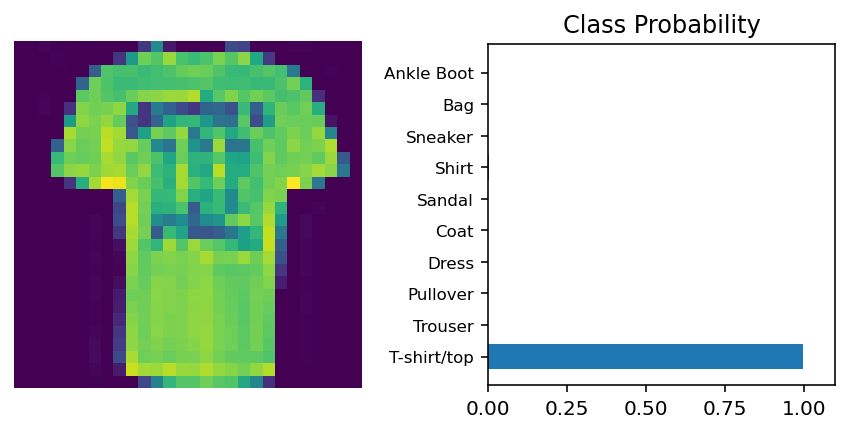

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

ps = model(img)
ps = torch.exp(ps)

view_classify(img, ps, version='Fashion')